In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [4]:
import sys

sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio")

# Dataset

In [5]:
import torch
import torch.nn.functional as F
from ay2.torchaudio.transforms.self_operation import CentralAudioClip
from torch.utils.data import DataLoader, Dataset, Sampler, default_collate, random_split

try:
    from .data.tools import WaveDataset
except ImportError:
    from data.tools import WaveDataset

In [6]:
def to_ds(_data):
    _ds = WaveDataset(
        _data,
        sample_rate=16000,
        normalize=True,
        transform=[CentralAudioClip(48000)],
        dtype="tensor",
    )
    _dl = DataLoader(_ds, batch_size=8, num_workers=4, shuffle=False, prefetch_factor=2, drop_last=False)
    return _dl

In [7]:
from ay2.datasets.audio import DECRO_AudioDs, InTheWild_AudioDs

![](https://cdn.jsdelivr.net/gh/RedamancyAY/CloudImage@main/img/202408141543959.png)

In [18]:
ds = DECRO_AudioDs(root_path="/home/ay/data/DATA/2-datasets/1-df-audio/DECRO")
data = ds.data.query('language == "ch"').reset_index(drop=True)  # only use en data
DECRO_real_data = data.query("label == 1").sample(3000).reset_index(drop=True)
DECRO_fake_data = data.query("label == 0").reset_index(drop=True)

In [44]:
DECRO_fake_data.method.unique()

array(['baidu', 'fs2', 'starganv2', 'vits', 'hifigan', 'mbmelgan',
       'Tacotron', 'xunfei', 'pwg', 'nvcnet', 'fs2mtts', 'StarGAN',
       'nvcnet-cn'], dtype=object)

# Load Model

In [8]:
from resnet import ResNet

In [9]:
_resnet = ResNet().cuda().eval()

In [28]:
def get_hidden_states_and_labels(model, _datas):
    hidden_states = []
    labels = []

    if not isinstance(_datas, list):
        _datas = [_datas]

    for _data in _datas:
        ds = to_ds(_data)
        for item in tqdm(ds):
            x = item["audio"].cuda()  ## (B, 1, 48000)
            with torch.no_grad():
                spec = model.preprocess(x)
                feat = model.extract_feature(spec)  # (B, 512)
                hidden_states.append(feat)
                labels += list(item["label"])
    hidden_states = torch.concat(hidden_states).detach().cpu()
    return hidden_states, labels

# t-SNE

In [11]:
from ay2.visualization.tsne import (
    add_rounded_rectangle_border_for_image,
    plot_tSNE_res,
    tSNE_cluster,
)

In [12]:
def get_subpart(_index, label):
    if labels[_index] == label:
        return True
    else:
        return False

In [32]:
def predict_and_plot(model, datas, method):
    hidden_states, labels = get_hidden_states_and_labels(model, datas)
    result = tSNE_cluster(hidden_states)

    def get_subpart(_index, label):
        if labels[_index] == label:
            return True
        else:
            return False

    plot_tSNE_res(
        result,
        point_labels=[1, 0],
        legend_labels=["Real", "Fake"],
        index_func=get_subpart,
        markers=["o", "^"],
        colors=["blue", "red"],
        save_path=None,
        add_lefttop_text=method,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:08<00:00, 51.60it/s]


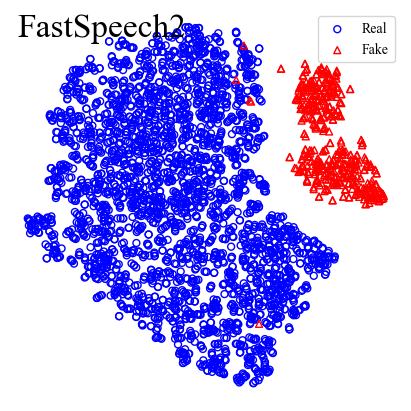

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:09<00:00, 49.88it/s]


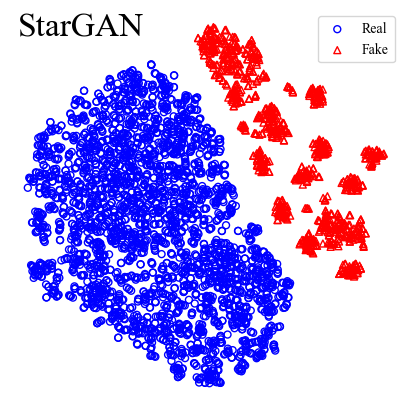

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:24<00:00, 30.95it/s]


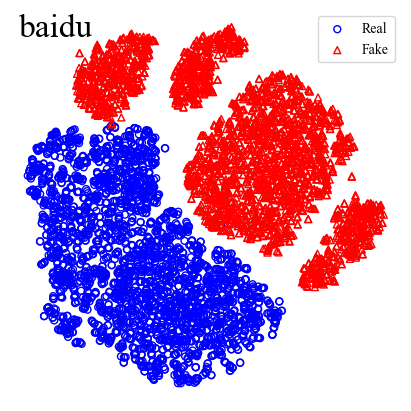

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:12<00:00, 48.78it/s]


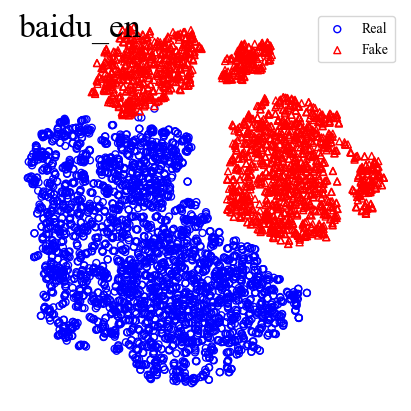

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 545/545 [00:08<00:00, 61.89it/s]


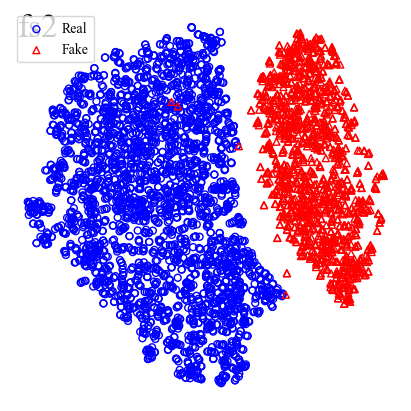

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.46it/s]


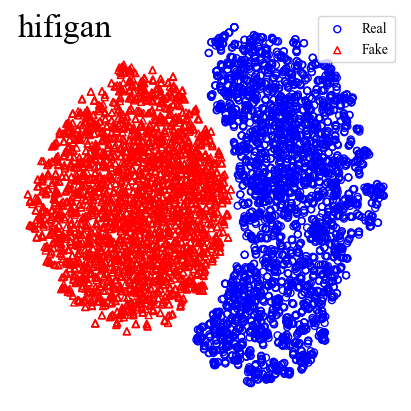

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.23it/s]


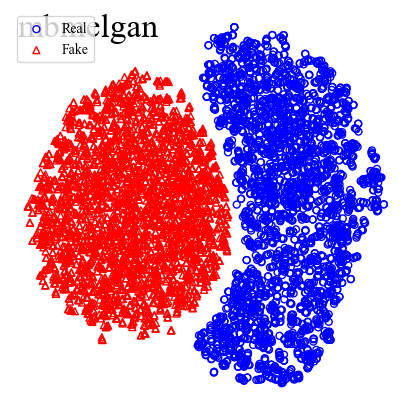

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.85it/s]


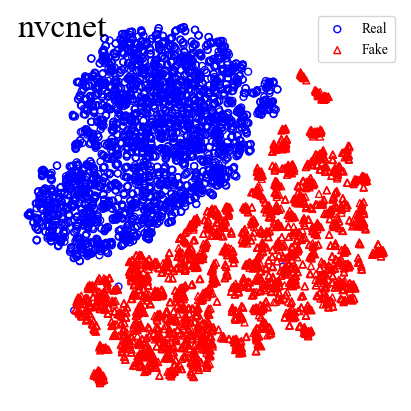

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:24<00:00, 31.23it/s]


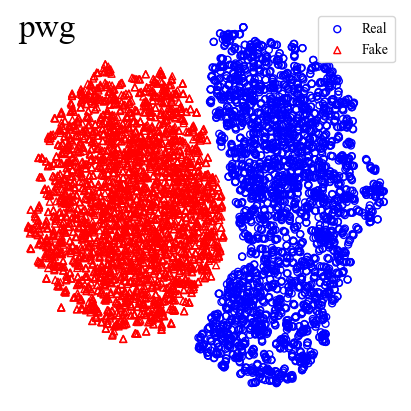

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:22<00:00, 31.97it/s]


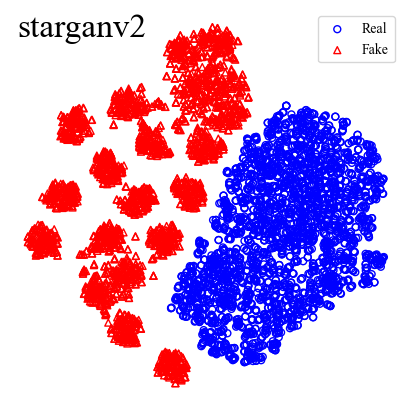

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:14<00:00, 53.27it/s]


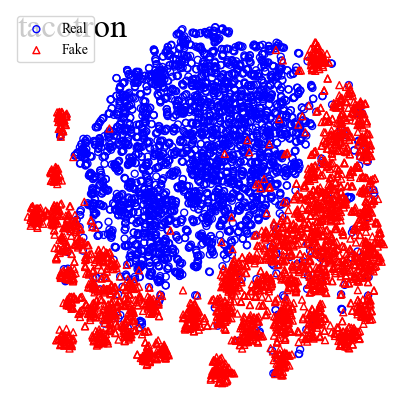

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 61.41it/s]


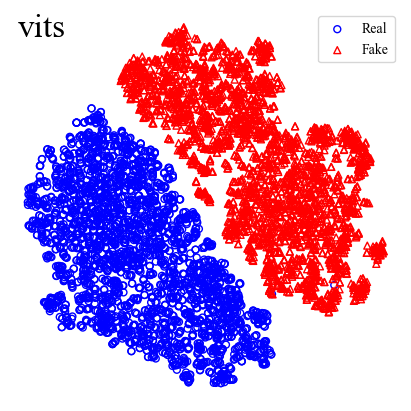

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:16<00:00, 34.53it/s]


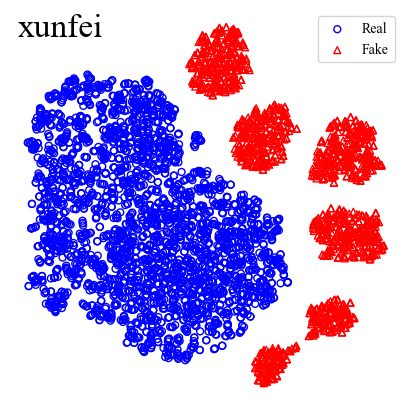

In [37]:
for method in [
    "FastSpeech2",
    "StarGAN",
    "baidu",
    "baidu_en",
    "fs2",
    "hifigan",
    "mbmelgan",
    "nvcnet",
    "pwg",
    "starganv2",
    "tacotron",
    "vits",
    "xunfei",
]:
    fake_data = data.query(f'method == "{method}"').reset_index(drop=True)
    fake_data = fake_data.sample(min(3000, len(fake_data))).reset_index(drop=True)
    predict_and_plot(_resnet, DECRO_real_data, fake_data, method)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:36<00:00, 20.28it/s]


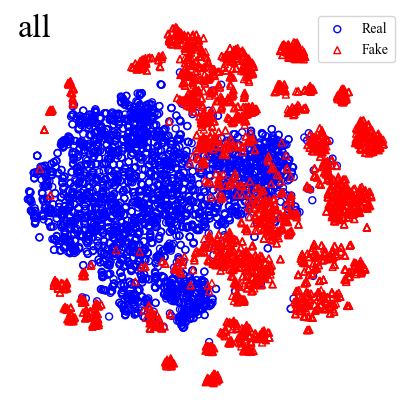

In [19]:
fake_data = DECRO_fake_data.sample(3000).reset_index(drop=True)
predict_and_plot(_resnet, DECRO_real_data, fake_data, "all")

# IntheWild

In [14]:
ds = InTheWild_AudioDs(root_path="/home/ay/data/DATA/2-datasets/1-df-audio/release_in_the_wild")

In [15]:
data = ds.data
ITW_real_data = data.query("label == 1").reset_index(drop=True)
ITW_fake_data = data.query("label == 0").reset_index(drop=True)

In [16]:
torch.multiprocessing.set_sharing_strategy("file_system")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3973/3973 [00:19<00:00, 204.85it/s]


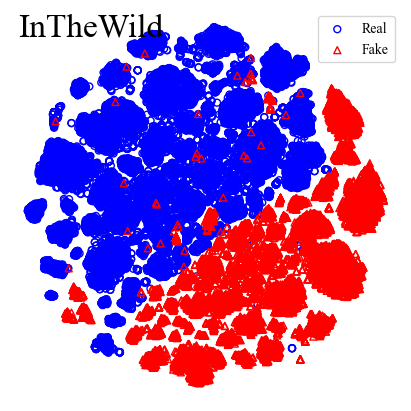

In [17]:
predict_and_plot(_resnet, ITW_real_data, ITW_fake_data, "InTheWild")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 199.87it/s]


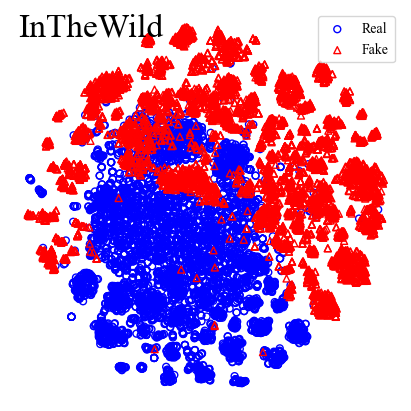

In [34]:
predict_and_plot(
    _resnet,
    [
        ITW_real_data.sample(3000).reset_index(drop=True),
        DECRO_real_data.sample(3000).reset_index(drop=True),
        DECRO_fake_data.sample(3000).reset_index(drop=True),
        ITW_fake_data.sample(3000).reset_index(drop=True),
    ],
    "InTheWild",
)